In [ ]:
!pip install pystac
!pip install pystac_client
!pip install planetary_computer
!pip install nb_black
!pip install odc-stac
!pip install geopandas
!pip install rioxarray
!pip install loguru
!pip install opencv-python
!pip install geopy
!pip install path
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.0 MB/s eta 0:00:00


In [ ]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from google.colab import drive

plt.style.use('Solarize_Light2')

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RANDOM_STATE = 42
DATA_DIR =  Path("/content/drive/MyDrive/Data Science/tick-tick-bloom-challenge/data")
assert DATA_DIR.exists()

metadata = pd.read_csv(DATA_DIR / "metadata.csv")
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv")
sample_submission = pd.read_csv(DATA_DIR / "submission_format.csv")

In [ ]:
n_train = metadata["split"].value_counts()["train"]
n_test = metadata["split"].value_counts()["test"]

print(f"Number of training examples: {n_train}")
print(f"Number of testing examples: {n_test}")

Number of training examples: 17060
Number of testing examples: 6510


In [ ]:
# merge training metadata with labels
data = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)
data.head()

,uid,region,severity,density,latitude,longitude,date,split
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train


# **Process feature data**

In [ ]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [ ]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [ ]:
import geopy.distance as distance
import cv2

    


def otsu_binarization(image, mask=None):
    if mask is None:
        mask = ~np.isnan(image)
    else:
        mask = np.all([mask, ~np.isnan(image)], axis=0)
    
    pixel_values, counts = np.unique(image[mask], return_counts=True)
    probabilities = counts / image[mask].size
    thresholds = pixel_values[1:]
    if len(thresholds) <= 1:
        return np.full_like(image, False, dtype=bool)
    best_threshold = None
    max_y = float('-inf')
    for threshold in tqdm(thresholds):
        pixel_value0 = pixel_values[pixel_values < threshold]
        pixel_value1 = pixel_values[pixel_values >= threshold]

        probabilities0 = probabilities[pixel_values < threshold]
        probabilities1 = probabilities[pixel_values >= threshold]
        w0 = probabilities0.sum()
        w1 = probabilities1.sum()
        mu0 = (pixel_value0 * probabilities0).sum() / w0
        mu1 = (pixel_value1 * probabilities1).sum() / w1

        u = w0*mu0 + w1*mu1
        y = w0 * (mu0 - u)**2 + w1 * (mu1 - u)**2

        if y > max_y:
            best_threshold = threshold
            max_y = y

    binarized_image = np.all(np.array([image >= best_threshold, mask]), axis=0)
    return binarized_image

def get_water_algae_masks(water_index, algae_index):
    #extracted_water = otsu_binarization(water_index)
    ret, _ = cv2.threshold(water_index, 0, water_index.max(), cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    extracted_water = np.full_like(ret, True, dtype=bool)
    extracted_water[ret == 0] = False
    extracted_algae = otsu_binarization(algae_index, extracted_water)
    return extracted_water, extracted_algae

# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range

def resize_images(*imgs):
    img_shapes = [img.shape for img in imgs]
    h, w = float('inf'), float('inf')
    for shape in img_shapes:
        h_temp, w_temp = shape
        if h_temp < h:
            h = h_temp
        if w_temp < w:
            w = w_temp
    return (cv2.resize(img, dsize=(h, w), interpolation=cv2.INTER_CUBIC) for img in imgs)

def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    b01 = rioxarray.open_rasterio(pc.sign(item.assets["B01"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]
    b02 = rioxarray.open_rasterio(pc.sign(item.assets["B02"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]
    b03 = rioxarray.open_rasterio(pc.sign(item.assets["B03"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]
    b04 = rioxarray.open_rasterio(pc.sign(item.assets["B04"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]
    b05 = rioxarray.open_rasterio(pc.sign(item.assets["B05"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]
    b06 = rioxarray.open_rasterio(pc.sign(item.assets["B06"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]
    # b07 = rioxarray.open_rasterio(pc.sign(item.assets["B07"].href)).rio.clip_box(
    #     minx=minx,
    #     miny=miny,
    #     maxx=maxx,
    #     maxy=maxy,
    #     crs="EPSG:4326",
    # ).to_numpy()[0]
    b08 = rioxarray.open_rasterio(pc.sign(item.assets["B08"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]
    # b09 = rioxarray.open_rasterio(pc.sign(item.assets["B09"].href)).rio.clip_box(
    #     minx=minx,
    #     miny=miny,
    #     maxx=maxx,
    #     maxy=maxy,
    #     crs="EPSG:4326",
    # ).to_numpy()[0]
    b11 = rioxarray.open_rasterio(pc.sign(item.assets["B11"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]

    b12 = rioxarray.open_rasterio(pc.sign(item.assets["B12"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]
    b8a = rioxarray.open_rasterio(pc.sign(item.assets["B8A"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()[0]

    visual = np.moveaxis(rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy(), 0, -1)

    # Normalized Difference Water Index
    #b02_copy, b08_copy = resize_images(b02, b08)
    #ndwi = (b02_copy - b08_copy) / (b02_copy + b08_copy)

    # Modified Normalized Difference Water Index
    #b03_copy, b11_copy = resize_images(b03, b11)
    #mndwi = (b03_copy - b11_copy) / (b03_copy + b11_copy)

    # Snow Water Index
    b05_copy, b11_copy = resize_images(b05, b11)
    swi = (b05_copy - b11_copy) / (b05_copy + b11_copy)

    # Floating Algae Index
    #fai = 
    # Adjusted Floating Algae Index
    #afai = 

    # Normalized Difference Vegetation Index
    b08_copy, b04_copy = resize_images(b08, b04)
    ndvi = (b08_copy - b04_copy) / (b08_copy + b04_copy)

    # Enhanced Vegetation Index
    #b08_copy, b04_copy, b02_copy = resize_images(b08, b04, b02)
    #evi = 2.5*((b08_copy - b04_copy) / (b08_copy + 6*b04_copy - 7.5*b02_copy + 1))

    # Algal Bloom Detection Index
    b03_copy, b04_copy, b06_copy, b08_copy = resize_images(b03, b04, b06, b08)
    abdi = (b06_copy - b04_copy - (b08_copy - b04_copy) * (740.5 - 664.6) / (832.8 - 664.6)) - (b04_copy - 0.5*b03_copy)

    water_mask, algae_mask = get_water_algae_masks(swi, abdi)

    images = {'Coastal': b01,
              'Red': b04,
              'Green': b03,
              'Blue': b02,
              'NIR': b08,
              'SWIR16': b11,
              'SWIR22': b12,
              'Narrow NIR': b8a,
              'Visual': visual,
              'SWI': swi,
              'NDVI': ndvi,
              #'EVI': evi,
              'ABDI': abdi,
              'Water mask': water_mask,
              'Algae mask': algae_mask}

    return images


def crop_landsat8_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    landsat_bands = ['red', 'blue', 'green', 'coastal',
                     'nir08', 'swir16', 'swir22']
    image = odc.stac.stac_load(
        [pc.sign(item)], bands=landsat_bands, bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = np.moveaxis(image[["red", "green", "blue"]].to_array().to_numpy(), 0, -1)
    red = image["red"].to_numpy()

    green = image["green"].to_numpy()
    blue = image["blue"].to_numpy()
    nir = image["nir08"].to_numpy()
    swir16 = image["swir16"].to_numpy()
    swir22 = image["swir22"].to_numpy()
    coastal = image["coastal"].to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    swi = green * (nir - swir16) / (green + nir) / (nir + swir16)
    fai = nir - (red + (swir16 - red)*(865 - 655)/(1609 - 655))
    ndvi = (nir - red) / (nir + red)
    water_mask, algae_mask = get_water_algae_masks(swi, fai)

    images = {'Red': red,
              'Green': green,
              'Blue': blue,
              'NIR': nir,
              'SWIR16': swir16,
              'SWIR22': swir22,
              'Coastal': coastal,
              'Visual': image_array,
              'NDVI': ndvi,
              'SWI': swi,
              'FAI': fai,
              'Water mask': water_mask,
              'Algae mask': algae_mask}
    return images

def crop_landsat7_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box
    landsat_bands = ['red', 'blue', 'green',
                     'nir08', 'swir16', 'swir22']
    image = odc.stac.stac_load(
        [pc.sign(item)], bands=landsat_bands, bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = np.moveaxis(image[["red", "green", "blue"]].to_array().to_numpy(), 0, -1)
    red = image["red"].to_numpy()

    green = image["green"].to_numpy()
    blue = image["blue"].to_numpy()
    nir = image["nir08"].to_numpy()
    swir16 = image["swir16"].to_numpy()
    swir22 = image["swir22"].to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    swi = green * (nir - swir16) / (green + nir) / (nir + swir16)
    fai = nir - (red + (swir16 - red)*(865 - 655)/(1609 - 655))
    ndvi = (nir - red) / (nir + red)
    water_mask, algae_mask = get_water_algae_masks(swi, fai)

    images = {'Red': red,
              'Green': green,
              'Blue': blue,
              'NIR': nir,
              'SWIR16': swir16,
              'SWIR22': swir22,
              'Visual': image_array,
              'NDVI': ndvi,
              'SWI': swi,
              'FAI': fai,
              'Water mask': water_mask,
              'Algae mask': algae_mask}
    return images


# Refactor our process from above into functions
# Refactor our process from above into functions
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    best_item = None
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    item_details["landsat"] = item_details.platform.str.lower().str.contains(
        "landsat"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

        # return the closest imagery by time
        listitems = item_details.sort_values(by="time_diff", ascending=True)

        for i in range(len(listitems)):
            cloud_coverage = listitems.iloc[i, 6].properties["eo:cloud_cover"]
            shadow_pixels = listitems.iloc[i, 6].properties[
                "s2:cloud_shadow_percentage"
            ]
            no_pixel_data = listitems.iloc[i, 6].properties[
                "s2:nodata_pixel_percentage"
            ]
            degraded_msi_data_percentage = listitems.iloc[i, 6].properties[
                "s2:degraded_msi_data_percentage"
            ]
            if (
                no_pixel_data < 10
                and cloud_coverage < 10
                and shadow_pixels < 10
                and degraded_msi_data_percentage < 10
            ):
                best_item = listitems.iloc[i]
    # if we have sentinel-2, filter to sentinel-2 images only
    else:
        item_details = item_details[item_details["landsat"] == True]
        listitems = item_details.sort_values(by="time_diff", ascending=True)
        for i in range(len(listitems)):
            # return the closest imagery by time
            cloud_coverage_land = listitems.iloc[i, 6].properties[
                "landsat:cloud_cover_land"
            ]
            cloud_coverage = listitems.iloc[i, 6].properties["eo:cloud_cover"]
            if cloud_coverage < 10 and cloud_coverage_land < 10:
                best_item = listitems.iloc[i]
    if best_item is None:
        return None, None, None
    return (
        best_item["item_obj"],
        best_item["platform"],
        best_item["datetime"],
    )




def images_to_features(*images):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    resized_images = np.array(list(resize_images(*images)))
    averages = resized_images.mean(axis=(1, 2))
    medians = np.median(resized_images, axis=(1, 2))

    return averages, medians

In [ ]:
import rioxarray
import imageio
from IPython.display import Image
from PIL import Image as PILImage
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd



def extract_image(row):
    latitude, longitude, date = row[['latitude', 'longitude', 'date']]
    ## QUERY STAC API
    # get query ranges for location and date
    search_bbox = get_bounding_box(
        latitude, longitude, meter_buffer=50000
    )
    date_range = get_date_range(date, time_buffer_days=30)

    # search the planetary computer
    search = catalog.search(
        collections=["sentinel-2-l2a", "landsat-c2-l2"],
        bbox=search_bbox,
        datetime=date_range,
    )
    items = [item for item in search.get_all_items()]

    ## GET BEST IMAGE
    if not len(items):
        return None

    best_item, item_platform, item_date = select_best_item(
        items, date, latitude, longitude
    )
    if best_item is None:
        return (None for _ in range(4))

    ## CONVERT TO FEATURES
    # get small bbox just for features
    feature_bbox = get_bounding_box(
        latitude, longitude, meter_buffer=3000
    )

    # crop the image
    lowered_item_platform = item_platform.lower()
    if "sentinel" in lowered_item_platform:
        images = crop_sentinel_image(best_item, feature_bbox)
    elif "landsat" in lowered_item_platform:
        if '8' in lowered_item_platform:
            images = crop_landsat8_image(best_item, feature_bbox)
        else:
            images = crop_landsat7_image(best_item, feature_bbox)
    else:
        return best_item, item_platform, item_date, None


    return best_item, item_platform, item_date, images

In [ ]:
train_metadata = metadata[metadata["split"] == "train"].drop("split", axis=1)
sub_df = train_metadata.sample(1, random_state=42)

In [ ]:
%%time

sub_df.apply(extract_image, axis=1)

CPU times: user 61.9 ms, sys: 2.61 ms, total: 64.5 ms
Wall time: 430 ms


18933    <generator object extract_image.<locals>.<gene...
dtype: object

In [ ]:
%%time
sub_df.swifter.apply(extract_image, axis=1)

Pandas Apply:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-60-21cf04f0ad0d>:269: RuntimeWarning: invalid value encountered in true_divide
  swi = green * (nir - swir16) / (green + nir) / (nir + swir16)
<ipython-input-60-21cf04f0ad0d>:271: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir - red) / (nir + red)
<ipython-input-60-21cf04f0ad0d>:315: RuntimeWarning: invalid value encountered in true_divide
  swi = green * (nir - swir16) / (green + nir) / (nir + swir16)
<ipython-input-60-21cf04f0ad0d>:317: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir - red) / (nir + red)
<ipython-input-60-21cf04f0ad0d>:269: RuntimeWarning: invalid value encountered in true_divide
  swi = green * (nir - swir16) / (green + nir) / (nir + swir16)
<ipython-input-60-21cf04f0ad0d>:271: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir - red) / (nir + red)


CPU times: user 5min 43s, sys: 2.34 s, total: 5min 46s
Wall time: 6min 43s


18933    <generator object extract_image.<locals>.<gene...
4341     (<Item id=LC08_L2SP_015036_20141001_02_T1>, la...
16865    (<Item id=S2B_MSIL2A_20190921T155939_R097_T17S...
18889    (<Item id=LE07_L2SP_044034_20131220_02_T1>, la...
985      <generator object extract_image.<locals>.<gene...
11441    (<Item id=S2B_MSIL2A_20210713T184919_R113_T10S...
10651    <generator object extract_image.<locals>.<gene...
11006    (<Item id=S2A_MSIL2A_20170612T153911_R011_T18T...
12357    <generator object extract_image.<locals>.<gene...
7868     (<Item id=LC08_L2SP_015035_20150817_02_T1>, la...
dtype: object

In [ ]:
images.keys()

dict_keys(['Red', 'Green', 'Blue', 'NIR', 'SWIR16', 'SWIR22', 'Coastal', 'Visual', 'SWI', 'FAI', 'Water mask', 'Algae mask'])

In [ ]:
image_arrays = [images['Red'], images['Green'], images['Blue'], images['NIR'],
                images['SWIR16'], images['SWIR22'], images['Coastal']]

features = images_to_features(*image_arrays)

In [ ]:
features[1].shape

(7,)

In [ ]:
plt.imshow(images['Visual'])
plt.show()
plt.imshow(images['SWI'])
plt.show()
plt.imshow(images['FAI'])
plt.show()
plt.imshow(images['Water mask'])
plt.show()
plt.imshow(images['Algae mask'])
plt.show()

In [ ]:
best_item.assets.keys()

dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])

In [ ]:
best_item.assets['rendered_preview']

href: https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-c2-l2&item=LC08_L2SP_044034_20141231_02_T1&assets=red&assets=green&assets=blue&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55&format=png
Title: Rendered preview
Media type: image/png
Roles: ['overview']
Owner:
rel: preview


In [ ]:
images.keys()

dict_keys(['Visual', 'NDWI', 'MNDWI', 'SWI', 'NDVI', 'EVI', 'ABDI'])

In [ ]:

images['SWI'].min()

0.002012072434607646

100%|██████████| 276/276 [00:00<00:00, 28669.06it/s]


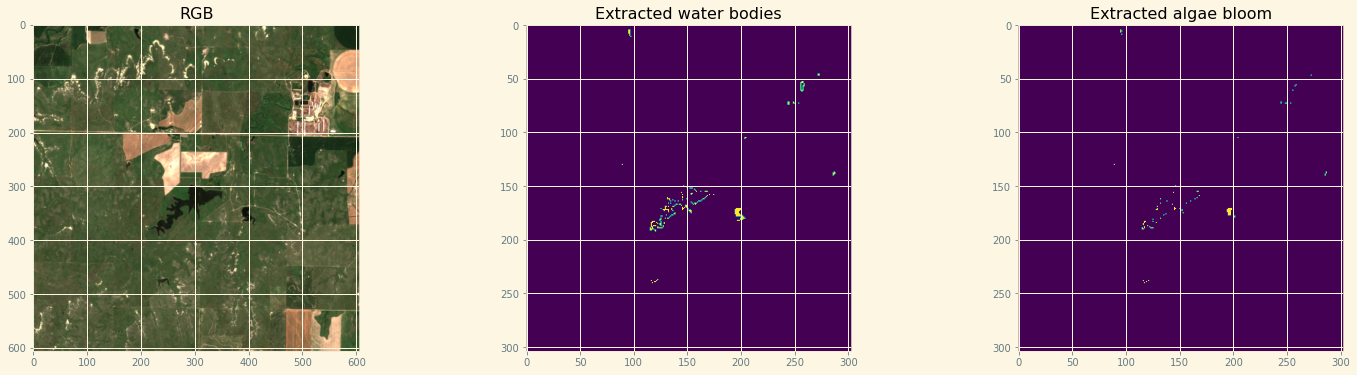

In [ ]:
visual = images['Visual']
swi = images['SWI']
abdi = images['ABDI']

extracted_water = otsu_binarization(swi)
extracted_algae = otsu_binarization(abdi, extracted_water)

fig, axes = plt.subplots(1, 3, figsize=(25, 6))
axes[0].set_title('RGB')
axes[0].imshow(visual)
axes[1].set_title('Extracted water bodies')
axes[1].imshow(extracted_water)
axes[2].set_title('Extracted algae bloom')
axes[2].imshow(extracted_algae)
plt.show()


<ipython-input-19-7805bea99a37>:175: RuntimeWarning: divide by zero encountered in true_divide
  evi = 2.5*((b08_copy - b04_copy) / (b08_copy + 6*b04_copy - 7.5*b02_copy + 1))
100%|██████████| 3701/3701 [00:00<00:00, 20688.64it/s]


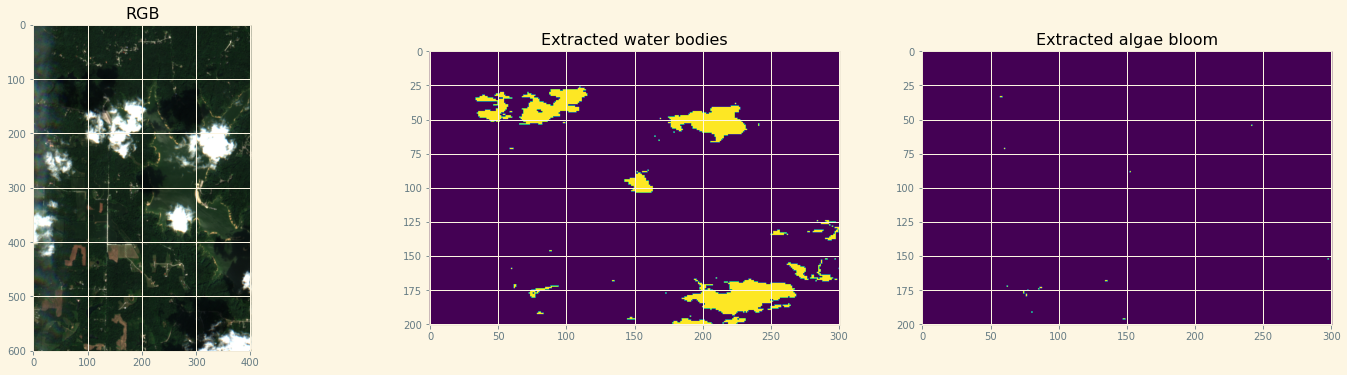

In [ ]:

latitude, longitude, date = train_metadata.loc[5, ["latitude", "longitude", "date"]]
best_item, item_platform, item_date, images = extract_image(latitude, longitude, date)

visual = images['Visual']
swi = images['SWI']
abdi = images['ABDI']

extracted_water = otsu_binarization(swi)
extracted_algae = otsu_binarization(abdi, extracted_water)

fig, axes = plt.subplots(1, 3, figsize=(25, 6))
axes[0].set_title('RGB')
axes[0].imshow(visual)
axes[1].set_title('Extracted water bodies')
axes[1].imshow(extracted_water)
axes[2].set_title('Extracted algae bloom')
axes[2].imshow(extracted_algae)
plt.show()


In [ ]:
extracted_algae.sum() / extracted_water.sum()

0.005361930294906166

In [ ]:
probabilities

array([2.45074012e-05, 2.72304458e-06, 2.72304458e-06, ...,
       2.72304458e-06, 2.72304458e-06, 2.72304458e-06])

In [ ]:
images['ABDI'].max()

65460.41868427488

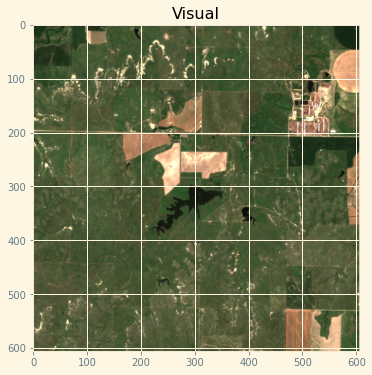

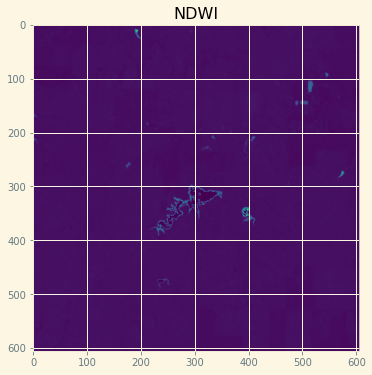

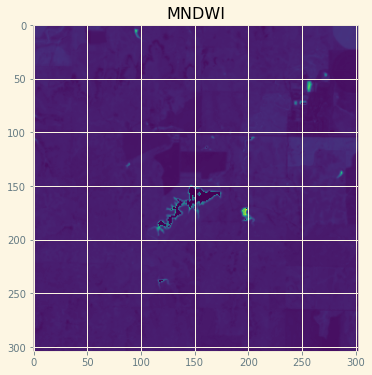

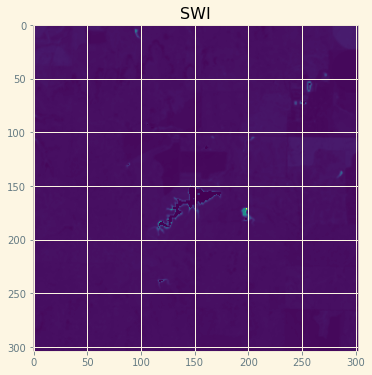

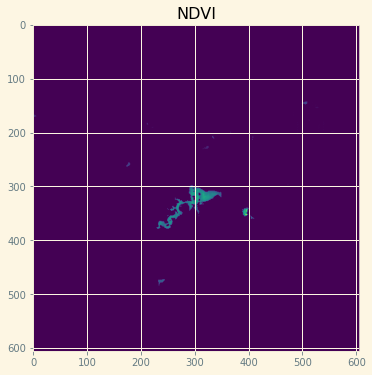

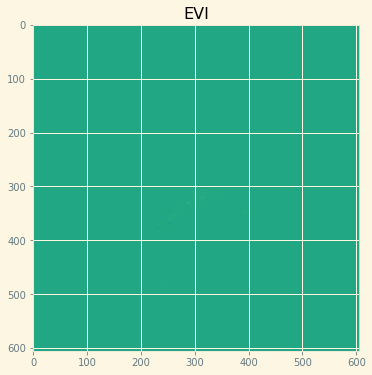

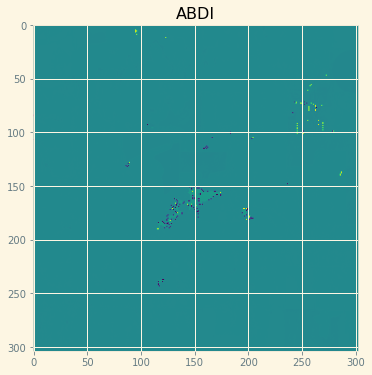

In [ ]:
for index_name, image in images.items():
    plt.figure(figsize=(6, 6))
    plt.title(index_name)
    plt.imshow(image)
    plt.show()

In [ ]:
best_item

ID: S2A_MSIL2A_20190712T171901_R012_T14SMH_20201005T125646
"Bounding Box: [-100.15274, 37.85395064837389, -98.88751, 38.84894433319432]"
Datetime: 2019-07-12 17:19:01.024000+00:00
datetime: 2019-07-12T17:19:01.024000Z
platform: Sentinel-2A
proj:epsg: 32614
instruments: ['msi']
s2:mgrs_tile: 14SMH
constellation: Sentinel 2
s2:granule_id: S2A_OPER_MSI_L2A_TL_ESRI_20201005T125648_A021173_T14SMH_N02.12
eo:cloud_cover: 1.341402


In [ ]:
item_platform

'Sentinel-2B'

In [ ]:
best_item

ID: S2B_MSIL2A_20180508T162859_R083_T16SEJ_20201012T073059
"Bounding Box: [-87.00023345437725, 38.754036048213806, -85.71871965132907, 39.7502679270046]"
Datetime: 2018-05-08 16:28:59.027000+00:00
datetime: 2018-05-08T16:28:59.027000Z
platform: Sentinel-2B
proj:epsg: 32616
instruments: ['msi']
s2:mgrs_tile: 16SEJ
constellation: Sentinel 2
s2:granule_id: S2B_OPER_MSI_L2A_TL_ESRI_20201012T073102_A006115_T16SEJ_N02.12
eo:cloud_cover: 0.159439


Import train images

In [ ]:
import rioxarray
import imageio
from IPython.display import Image
from PIL import Image as PILImage
from joblib import Parallel, delayed
import multiprocessing

# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items = {}
selected_images = {}
features_dict = {}
errored_ids = []
found_images = 0
bestitemselected = 0

for row in tqdm(train_subset.itertuples(), total=len(train_subset)):
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=3000
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            image = np.transpose(image_array, axes=[1, 2, 0]).astype(np.uint8)
            # selected_items[row.uid] = {"image_array": image_array}
            imageio.imwrite(IMAGE_ARRAY_DIR / f"{row.uid}.png", image)

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

  1%|          | 94/17060 [01:12<3:25:06,  1.38it/s]<ipython-input-20-5860cfa8e27a>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
<ipython-input-20-5860cfa8e27a>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_details["sentinel"] = item_details.platform.str.lower().str.contains(
  1%|          | 138/17060 [01:53<3:44:13,  1.26it/s]<ipython-input-20-5860cfa8e27a>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [ ]:
errored_ids

['aahy', 'aaia', 'aaie']

In [ ]:
selected_items

{'aabm': {'item_object': <Item id=S2B_MSIL2A_20180508T162859_R083_T16SEJ_20201012T073059>,
  'item_platform': 'Sentinel-2B',
  'item_date': '2018-05-08'},
 'aacd': {'item_object': <Item id=S2B_MSIL2A_20201104T160439_R097_T17SPV_20201106T105150>,
  'item_platform': 'Sentinel-2B',
  'item_date': '2020-11-04'},
 'aaee': {'item_object': <Item id=S2A_MSIL2A_20160822T155902_R097_T17SPV_20210528T230810>,
  'item_platform': 'Sentinel-2A',
  'item_date': '2016-08-22'},
 'aaff': {'item_object': <Item id=S2A_MSIL2A_20190712T171901_R012_T14SMH_20201005T125646>,
  'item_platform': 'Sentinel-2A',
  'item_date': '2019-07-12'},
 'aafl': {'item_object': <Item id=S2B_MSIL2A_20210823T163839_R126_T16SDJ_20210824T051720>,
  'item_platform': 'Sentinel-2B',
  'item_date': '2021-08-23'},
 'aafp': {'item_object': <Item id=S2B_MSIL2A_20171031T160359_R097_T17SPV_20201015T033033>,
  'item_platform': 'Sentinel-2B',
  'item_date': '2017-10-31'},
 'aagm': {'item_object': <Item id=S2A_MSIL2A_20200602T155911_R097_T17S

In [ ]:
import rioxarray
import imageio
from IPython.display import Image
from PIL import Image as PILImage
from joblib import Parallel, delayed
import multiprocessing

# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items_test = {}
selected_images_test = {}
features_dict_test = {}
errored_ids_test = []
found_images_test = 0
bestitemselected_test = 0

for row in tqdm(test_subset.itertuples(), total=len(test_subset)):
    image_array_pth = IMAGE_ARRAY_DIR_TEST / f"{row.uid}.npy"  ##????????

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=3000
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            image = np.transpose(image_array, axes=[1, 2, 0]).astype(np.uint8)
            # selected_items[row.uid] = {"image_array": image_array}
            imageio.imwrite(IMAGE_ARRAY_DIR_TEST / f"{row.uid}.png", image)

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

100%|██████████| 6510/6510 [1:43:14<00:00,  1.05it/s]   


DATALOADERS

In [ ]:
import os
import stat
from PIL import Image

paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))
path_list = os.path.split(paths[0])
id = path_list[1][:4]

im = Image.open(path_list[0] + "\\" + path_list[1])
np.asarray(im).shape

(605, 604, 3)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import os
import stat
from PIL import Image

c:\Users\Administrateur\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, IMAGE_ARRAY_DIR):
        self.image_paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))

    def load_image(self, index: int):
        image_path = self.image_paths[index]
        path_list = os.path.split(image_path)
        id = path_list[1][:4]
        return transforms.Resize((610, 610))(
            Image.open(path_list[0] + "\\" + path_list[1])
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img = self.load_image(index)
        image_path = self.image_paths[index]
        path_list = os.path.split(image_path)
        id = path_list[1][:4]
        y = train_labels[train_labels.uid == id]["severity"]
        return np.asarray(img).T, np.asarray(y)

In [ ]:
train_dataset = Dataset(IMAGE_ARRAY_DIR)
test_dataset = Dataset(IMAGE_ARRAY_DIR_TEST)

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=32, num_workers=0, shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=32, num_workers=0, shuffle=True
)

MODEL

In [ ]:
from torchvision.models import resnet50
from torchsummary import summary

model = resnet50()
# replace the last fully-connected layer with our own classifier
num_ftrs = model.fc.in_features
num_classes = 5
model.fc = nn.Linear(num_ftrs, num_classes)
summary(model, (3, 610, 610))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 305, 305]           9,408
       BatchNorm2d-2         [-1, 64, 305, 305]             128
              ReLU-3         [-1, 64, 305, 305]               0
         MaxPool2d-4         [-1, 64, 153, 153]               0
            Conv2d-5         [-1, 64, 153, 153]           4,096
       BatchNorm2d-6         [-1, 64, 153, 153]             128
              ReLU-7         [-1, 64, 153, 153]               0
            Conv2d-8         [-1, 64, 153, 153]          36,864
       BatchNorm2d-9         [-1, 64, 153, 153]             128
             ReLU-10         [-1, 64, 153, 153]               0
           Conv2d-11        [-1, 256, 153, 153]          16,384
      BatchNorm2d-12        [-1, 256, 153, 153]             512
           Conv2d-13        [-1, 256, 153, 153]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
):
    model.train()

    train_loss = 0

    for batch, (image, label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(image)

        loss = loss_fn(output, label)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    model.eval()

    test_loss = 0
    with torch.no_grad():
        for i, (image, label) in enumerate(dataloader):
            output = model(image)
            loss = loss_fn(output, label)
            test_loss += loss.item()
    test_loss /= len(dataloader)
    return test_loss

In [ ]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs,
):
    # Create empty results dictionary
    results = {"train_loss": [], "test_loss": []}

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )

        test_loss = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model_result = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=train_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=50,
)

Estimating the density for test_data using regression models

In [ ]:
data

,uid,region,severity,density,latitude,longitude,date,split
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train
...,...,...,...,...,...,...,...,...
17055,zzsv,south,3,113125.0,38.707825,-75.080867,2018-06-27,train
17056,zzuq,south,3,175726.0,35.794000,-79.015368,2015-08-06,train
17057,zzwo,midwest,2,48510.0,39.792190,-99.971050,2017-06-19,train
17058,zzwq,south,1,1271.0,35.794000,-79.012551,2015-03-24,train


predict region !

In [ ]:
reg_data = data.drop(columns=["uid", "split", "date", "region"], inplace=False)

In [ ]:
reg_data

,severity,density,latitude,longitude
0,1,585.0,39.080319,-86.430867
1,1,290.0,35.875083,-78.878434
2,1,1614.0,35.487000,-79.062133
3,3,111825.0,38.049471,-99.827001
4,4,2017313.0,39.474744,-86.898353
...,...,...,...,...
17055,3,113125.0,38.707825,-75.080867
17056,3,175726.0,35.794000,-79.015368
17057,2,48510.0,39.792190,-99.971050
17058,1,1271.0,35.794000,-79.012551


In [ ]:
#reg_data = pd.get_dummies(reg_data, columns=["region"])
#reg_data

,severity,density,latitude,longitude,region_midwest,region_northeast,region_south,region_west
0,1,585.0,39.080319,-86.430867,1,0,0,0
1,1,290.0,35.875083,-78.878434,0,0,1,0
2,1,1614.0,35.487000,-79.062133,0,0,1,0
3,3,111825.0,38.049471,-99.827001,1,0,0,0
4,4,2017313.0,39.474744,-86.898353,1,0,0,0
...,...,...,...,...,...,...,...,...
17055,3,113125.0,38.707825,-75.080867,0,0,1,0
17056,3,175726.0,35.794000,-79.015368,0,0,1,0
17057,2,48510.0,39.792190,-99.971050,1,0,0,0
17058,1,1271.0,35.794000,-79.012551,0,0,1,0


In [ ]:
y = reg_data["density"]
X = reg_data.drop(columns=["density", "severity"], inplace=False)
X

,latitude,longitude
0,39.080319,-86.430867
1,35.875083,-78.878434
2,35.487000,-79.062133
3,38.049471,-99.827001
4,39.474744,-86.898353
...,...,...
17055,38.707825,-75.080867
17056,35.794000,-79.015368
17057,39.792190,-99.971050
17058,35.794000,-79.012551


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into a train set (70%) and a validation set (30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


regressor = XGBRegressor(n_estimators=20, learning_rate=0.1, random_state=42)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_val)

# Calculate the mean absolute error of the predictions
mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)

# Calculate the explained variance score
explained_variance = r2_score(y_val, y_pred)
print("Explained Variance Score:", explained_variance)

Mean Absolute Error: 642498.5410088496
Explained Variance Score: 0.1263755872361514


In [ ]:
X_val

,latitude,longitude
13699,35.911730,-79.171737
3143,35.654024,-79.260116
12222,35.676140,-79.219036
13666,37.431200,-120.995000
720,35.753340,-97.865410
...,...,...
3705,35.477270,-78.889868
3955,39.746939,-87.075981
3375,35.742000,-79.208276
3428,36.110000,-78.904036


In [ ]:
test_subset

,uid,latitude,longitude,date,split
1,aabn,36.559700,-121.510000,2016-08-31,test
12,aair,33.042600,-117.076000,2014-11-01,test
14,aajw,40.703968,-80.293050,2015-08-26,test
15,aalr,38.972500,-94.672930,2019-08-26,test
16,aalw,34.279000,-118.905000,2018-01-08,test
...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test
23560,zzrv,36.875400,-121.561000,2019-09-17,test
23563,zzsx,34.210000,-78.929389,2019-07-16,test
23565,zzvv,36.708500,-121.749000,2014-12-02,test


In [ ]:
test = test_subset.drop(columns=["date", "uid", "split"], inplace=False)
test

,latitude,longitude
1,36.559700,-121.510000
12,33.042600,-117.076000
14,40.703968,-80.293050
15,38.972500,-94.672930
16,34.279000,-118.905000
...,...,...
23556,40.136410,-80.473740
23560,36.875400,-121.561000
23563,34.210000,-78.929389
23565,36.708500,-121.749000


In [ ]:
y_test = regressor.predict(test)

In [ ]:
train_subset["density"] = train_labels["density"]

In [ ]:
test_subset["density"] = y_test

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_18392\949941452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_subset["density"]=y_test


In [ ]:
test_subset

,uid,latitude,longitude,date,split,density
1,aabn,36.559700,-121.510000,2016-08-31,test,4.697722e+06
12,aair,33.042600,-117.076000,2014-11-01,test,2.283987e+06
14,aajw,40.703968,-80.293050,2015-08-26,test,1.253251e+05
15,aalr,38.972500,-94.672930,2019-08-26,test,2.968985e+05
16,aalw,34.279000,-118.905000,2018-01-08,test,2.283987e+06
...,...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test,1.527825e+05
23560,zzrv,36.875400,-121.561000,2019-09-17,test,4.697722e+06
23563,zzsx,34.210000,-78.929389,2019-07-16,test,7.456878e+04
23565,zzvv,36.708500,-121.749000,2014-12-02,test,5.099542e+06


creating features

In [ ]:
paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))
path_list = os.path.split(paths[0])
id = path_list[1][:4]

im = Image.open(path_list[0] + "\\" + path_list[1])
np.asarray(im).shape

(605, 604, 3)

In [ ]:
features_dict = {}
ids = []
import os
import stat
from PIL import Image

paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))
path_list = os.path.split(paths[0])
id = path_list[1][:4]

im = Image.open(path_list[0] + "\\" + path_list[1])
np.asarray(im).shape

for i in tqdm(range(len(paths))):
    path_list = os.path.split(paths[i])
    image_array = np.asarray(Image.open(path_list[0] + "\\" + path_list[1]))

    # convert image to 1-dimensional features
    image_features = image_to_features(image_array.T)
    features_dict[path_list[1][:4]] = [path_list[1][:4]] + image_features

100%|██████████| 6262/6262 [06:13<00:00, 16.75it/s]


In [ ]:
features_dict["aabm"]

['aabm',
 41.80846423293744,
 68.91657818400745,
 40.65198128181271,
 37.0,
 70.0,
 38.0]

In [ ]:
# bring features into a dataframe
image_features = pd.DataFrame(features_dict).T
image_features.columns = [
    "uid",
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
image_features.head()

,uid,red_average,green_average,blue_average,red_median,green_median,blue_median
aabm,aabm,41.808464,68.916578,40.651981,37.0,70.0,38.0
aacd,aacd,58.694434,58.83759,43.420349,39.0,42.0,26.0
aaee,aaee,37.174914,55.106826,27.210063,21.0,41.0,18.0
aaff,aaff,87.930222,94.751895,59.8973,77.0,89.0,53.0
aafl,aafl,43.458332,59.218384,46.278988,22.0,42.0,27.0


region feature is highly correlated with the classes ==> create a region column for test

In [ ]:
image_features.iloc[0]

red_average      41.808464
green_average    68.916578
blue_average     40.651981
red_median       37.000000
green_median     70.000000
blue_median      38.000000
Name: aabm, dtype: float64

In [ ]:
classifier_data = image_features.merge(
    data, how="left", left_on="uid", right_on="uid", validate="1:1"
)
classifier_data

,uid,red_average,green_average,blue_average,red_median,green_median,blue_median,region,severity,density,latitude,longitude,date,split
0,aabm,41.808464,68.916578,40.651981,37.0,70.0,38.0,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train
1,aacd,58.694434,58.83759,43.420349,39.0,42.0,26.0,south,1,290.0,35.875083,-78.878434,2020-11-19,train
2,aaee,37.174914,55.106826,27.210063,21.0,41.0,18.0,south,1,1614.0,35.487000,-79.062133,2016-08-24,train
3,aaff,87.930222,94.751895,59.8973,77.0,89.0,53.0,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train
4,aafl,43.458332,59.218384,46.278988,22.0,42.0,27.0,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6257,zzkp,143.65754,112.679125,81.072908,139.0,108.0,79.0,west,3,391600.0,42.238550,-111.853100,2017-07-18,train
6258,zzlt,38.648277,52.134057,32.834635,25.0,44.0,21.0,south,3,182856.0,35.836460,-78.976300,2016-05-24,train
6259,zzpz,30.824001,48.589496,29.571373,22.0,43.0,25.0,south,3,118603.0,35.726309,-79.125853,2019-07-17,train
6260,zzqy,86.799796,85.564742,59.468982,84.0,82.0,57.0,west,4,5548841.0,37.928600,-121.561000,2018-05-15,train


Stander deviation better than median 

In [ ]:
X=data.drop(columns=["date", "uid", "split","region",'severity'], inplace=False)
y=data['severity']


In [ ]:
image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array().to_numpy()

In [ ]:
row = metadata.iloc[0]
best_item, item_platform, item_date = select_best_item(
    items, row.date, row.latitude, row.longitude
)

NameError: name 'items' is not defined

In [ ]:
row = metadata.iloc[0]

## QUERY STAC API
# get query ranges for location and date
search_bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=50000)
date_range = get_date_range(row.date, time_buffer_days=15)

# search the planetary computer
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"],
    bbox=search_bbox,
    datetime=date_range,
)
items = [item for item in search.get_all_items()]

## GET BEST IMAGE
if len(items) == 0:
    pass
else:
    best_item, item_platform, item_date = select_best_item(
        items, row.date, row.latitude, row.longitude
    )
    # add to dictionary tracking best items
feature_bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=3000)

(minx, miny, maxx, maxy) = feature_bbox

NIR = rioxarray.open_rasterio(pc.sign(best_item.assets["B08"].href)).rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy,
    crs="EPSG:4326",
)
red = rioxarray.open_rasterio(pc.sign(best_item.assets["B04"].href)).rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy,
    crs="EPSG:4326",
)

In [ ]:
nir = NIR.to_numpy()
red = red.to_numpy()
im = np.concatenate((nir, red), axis=0)

In [ ]:
im.shape

(2, 605, 604)

In [ ]:
plt.imshow(im.T)

In [ ]:


            ## CONVERT TO FEATURES
            # get small bbox just for features


            # crop the image
if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
image = np.transpose(image_array, axes=[1, 2, 0]).astype(np.uint8)
            # selected_items[row.uid] = {"image_array": image_array}
imageio.imwrite(IMAGE_ARRAY_DIR_TEST / f"{row.uid}.png", image)

        # keep track of any that ran into errors without interrupting the process
